# Feature Scaling:

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler

df = pd.read_csv("/kaggle/input/telco-churn/Telco-churn.csv")
print("Initial shape:", df.shape)
print(df.head())

#Drop customerID 
df.drop("customerID", axis=1, inplace=True)

#Convert TotalCharges to numeric and handle missing values
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors="coerce")
df['TotalCharges'].fillna(df['TotalCharges'].median())

#Encode binary categorical columns
binary_cols = ["gender", "Partner", "Dependents", "PhoneService", "PaperlessBilling", "Churn"]
le = LabelEncoder()
for col in binary_cols:
    df[col] = le.fit_transform(df[col])

#Encode multi-category columns using one-hot encoding
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
multi_cat_cols = list(set(cat_cols) - set(binary_cols))
df = pd.get_dummies(df, columns=multi_cat_cols, drop_first=True)

#Split into features and target
from sklearn.model_selection import train_test_split
X = df.drop("Churn", axis=1)
y = df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#Scale numerical columns 
cols_to_scale = [col for col in ["tenure", "MonthlyCharges", "TotalCharges"] if col in X_train.columns]

scaler = StandardScaler()
X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

#Check final shapes
print("Train shape:", X_train.shape, " Test shape:", X_test.shape)
print("Scaled columns:", cols_to_scale)
print(X_train[cols_to_scale].head())



Initial shape: (7043, 21)
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingM

# Model Training with XGBoost

In [8]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

xgb_model = XGBClassifier(
    n_estimators=200,       
    learning_rate=0.1,     
    max_depth=6,           
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'    
)

#Train
xgb_model.fit(X_train, y_train)

#Predict
y_pred_xgb = xgb_model.predict(X_test)

# LogisticRegression Model

In [12]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")  # you can also use "most_frequent" for categorical
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)


from sklearn.linear_model import LogisticRegression
#Initialize the model
log_reg = LogisticRegression(max_iter=1000, random_state=42)

#Train the model on training data
log_reg.fit(X_train, y_train)

#Predict on the test set
y_pred = log_reg.predict(X_test)



# Advanced Evaluation:(Precision, Recall, and F1-Score)


XGBoost Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1035
           1       0.61      0.53      0.57       374

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409



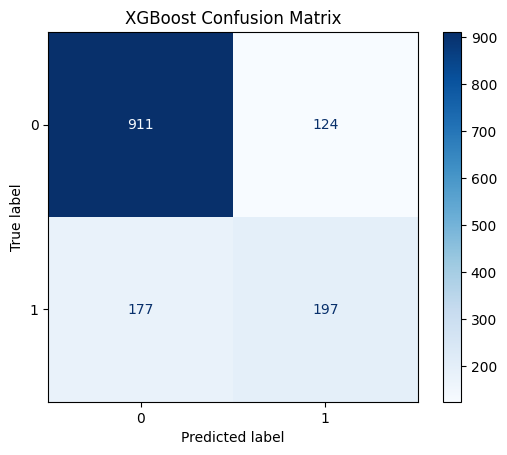

In [7]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print("XGBoost Classification Report:\n")
print(classification_report(y_test, y_pred_xgb))

#Confusion Matrix
cm = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_model.classes_)
disp.plot(cmap="Blues")
plt.title("XGBoost Confusion Matrix")
plt.show()


# Comparison:

In [15]:
# Logistic Regression Predictions
y_pred_logreg = log_reg.predict(X_test)

# XGBoost Predictions (or RandomForest if you chose that)
y_pred_adv = y_pred_xgb   # rename if using RF

# Function to calculate metrics
def get_metrics(y_true, y_pred, model_name):
    return {
        "Model": model_name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-Score": f1_score(y_true, y_pred)
    }

# Collect metrics for both models
results = []
results.append(get_metrics(y_test, y_pred_logreg, "Logistic Regression"))
results.append(get_metrics(y_test, y_pred_adv, "XGBoost"))

# Convert to DataFrame
comparison_df = pd.DataFrame(results)
print(comparison_df)



                 Model  Accuracy  Precision    Recall  F1-Score
0  Logistic Regression  0.805536   0.658228  0.556150  0.602899
1              XGBoost  0.786373   0.613707  0.526738  0.566906


# Model Comparison: Logistic Regression vs XGBoost

### Interpretation
- **Logistic Regression** performed better than **XGBoost** across all key metrics.  
- **Accuracy**: Logistic Regression achieved **80.6%**, higher than XGBoost’s **78.6%**.  
- **Precision**: Logistic Regression (**65.8%**) is slightly better than XGBoost (**61.4%**), meaning it makes fewer false churn predictions.  
- **Recall**: Logistic Regression (**55.6%**) > XGBoost (**52.7%**), which is important because Recall measures how well we identify actual churners.  
- **F1-Score**: Logistic Regression (**60.3%**) also outperforms XGBoost (**56.7%**), showing a better balance between Precision and Recall.  

### Conclusion
- For **GlobalMart’s churn prediction problem**:  
  Logistic Regression is the stronger model on this dataset, as it provides better **Recall** (critical for catching churners) and the highest **F1-score**.  

- **Business Impact**: Since the company wants to minimize customer loss, identifying churners correctly (**Recall**) is more valuable than overall Accuracy.  

- While **XGBoost** is a powerful model, it likely needs **hyperparameter tuning** to surpass Logistic Regression here. 
